<font color='tomato'><font color="#CC3D3D"><p>
# DeepCF 구현 실습

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Model Architecture   
<img align='left' src='http://drive.google.com/uc?export=view&id=1STWmli9f6Zps0Fr4Gxq6HYKN0_NzT2bi' width=800>

##### Imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import initializers
from keras.models import Model
from keras.layers import Input, Dense, Flatten, concatenate, Lambda, multiply
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from keras import backend as K
from time import time
import math
import heapq  # for retrieval topK

##### Global settings

In [3]:
# 하이퍼파라미터 설정

userlayers = [512, 64]
itemlayers = [1024, 64]
layers = [512,256,128,64]
learner = 'sgd'
learning_rate = 0.0001
batch_size = 512 # 논문에서는 256
num_epochs = 3 # 논문에서는 20
num_negatives = 2 # 논문에서는 4
topK = 10

##### Load data

In [4]:
# Train set: Movielens 데이터로부터 평점이 0보다 크면 1, 아니면 0인 이진 평점으로 변환한 평점 행렬
# 처리 속도를 높이기 위해 train set을 sparse matrix 형태(https://gaussian37.github.io/math-la-sparse_matrix 참조)로 저장
# Test set의 positive item 개수: 1, Negative item 개수: 최대 99개
# 논문에서는 6040명의 사용자를 대상으로 실험했으나, 본 실습에서는 시간 제약으로 사용자를 1000명으로 줄인 데이터 사용

train, testPositives, testNegatives = pd.read_pickle('/content/drive/Othercomputers/mypc/study/10_RecSystem/실습-20231014/DeepCF_data.pkl')
num_users, num_items = train.shape
print("#user=%d, #item=%d, #train=%d, #test=%d" %(num_users, num_items, train.nnz, len(testPositives)))
print("\ntrain-set:\n", train.toarray())
print("test-positives of user 0:\n", testPositives[0])
print("test-negatives of user 0:\n", testNegatives[0])

#user=1000, #item=3380, #train=154177, #test=1000

train-set:
 [[1. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
test-positives of user 0:
 [0, 25]
test-negatives of user 0:
 [1064, 174, 2791, 3373, 269, 2678, 1902, 1216, 915, 2803, 2344, 986, 3217, 2824, 2598, 464, 2340, 1952, 1855, 1353, 1547, 3293, 1541, 2414, 2728, 340, 1421, 1963, 2545, 972, 487, 2727, 1135, 3135, 128, 175, 2423, 1974, 2515, 3278, 3079, 1527, 2182, 1018, 2800, 1830, 1539, 617, 247, 1699, 1420, 2487, 198, 811, 1010, 1423, 2840, 1770, 881, 1913, 1803, 1734, 3326, 1617, 224, 3352, 1869, 1182, 1331, 336, 2517, 1721, 273, 1026, 1991, 2190, 998, 3369, 185, 2822, 864, 2854, 3067, 58, 2551, 2333, 2688, 1300, 1924, 3118]


##### Build model

In [5]:
""" tf.gather 기능: 행/열을 기준으로 indices로 지정된 행/열을 불러오는 방법
params = tf.constant([[10.0, 11.0, 12.0],
                      [20.0, 21.0, 22.0],
                      [30.0, 31.0, 32.0],
                      [40.0, 41.0, 42.0]])
print(params)
tf.gather(params, indices=2).numpy()
"""

' tf.gather 기능: 행/열을 기준으로 indices로 지정된 행/열을 불러오는 방법\nparams = tf.constant([[10.0, 11.0, 12.0],\n                      [20.0, 21.0, 22.0],\n                      [30.0, 31.0, 32.0],\n                      [40.0, 41.0, 42.0]])\nprint(params)\ntf.gather(params, indices=2).numpy()\n'

In [6]:
dmf_num_layer = len(userlayers)  # Number of layers in the DMF
mlp_num_layer = len(layers)      # Number of layers in the MLP
user_matrix = K.constant(train.toarray())   # sparse matrix => dense matrix => TF tensor
item_matrix = K.constant(train.toarray().T) # sparse matrix => dense matrix => transposed matrix => TF tensor

# Input variables
user_input = Input(shape=(1,), dtype='int32', name='user_input')
item_input = Input(shape=(1,), dtype='int32', name='item_input')

# Embedding layer
user_rating = Lambda(lambda x: tf.gather(user_matrix, x))(user_input) # 위 셀의 tf.gather 기능 참조
item_rating = Lambda(lambda x: tf.gather(item_matrix, x))(item_input)
user_rating = Flatten()(user_rating)  # 2D Tensor (1, num_items) => 1D Tensor (num_items,)
item_rating = Flatten()(item_rating)  # 2D Tensor (1, num_users) => 1D Tensor (num_users,)

# DMF part
dmf_user_latent = Dense(userlayers[0], activation="linear" , name='user_layer0')(user_rating)
dmf_item_latent = Dense(itemlayers[0], activation="linear" , name='item_layer0')(item_rating)
for idx in range(1, dmf_num_layer):
    dmf_user_latent = Dense(userlayers[idx], activation='relu', name='user_layer%d' % idx)(dmf_user_latent)
    dmf_item_latent = Dense(itemlayers[idx], activation='relu', name='item_layer%d' % idx)(dmf_item_latent)
dmf_vector = multiply([dmf_user_latent, dmf_item_latent])  # element-wise product

# MLP part
mlp_user_latent = Dense(layers[0]//2, activation="linear" , name='user_embedding')(user_rating)
mlp_item_latent  = Dense(layers[0]//2, activation="linear" , name='item_embedding')(item_rating)
mlp_vector = concatenate([mlp_user_latent, mlp_item_latent])
for idx in range(1, mlp_num_layer):
    mlp_vector = Dense(layers[idx], activation='relu', name="layer%d" % idx)(mlp_vector)

# Concatenate DMF and MLP parts
predict_vector = concatenate([dmf_vector, mlp_vector])

# Final prediction layer
prediction = Dense(1, activation='sigmoid', kernel_initializer=initializers.lecun_normal(),
                   name="prediction")(predict_vector)

model = Model(inputs=[user_input, item_input], outputs=prediction)

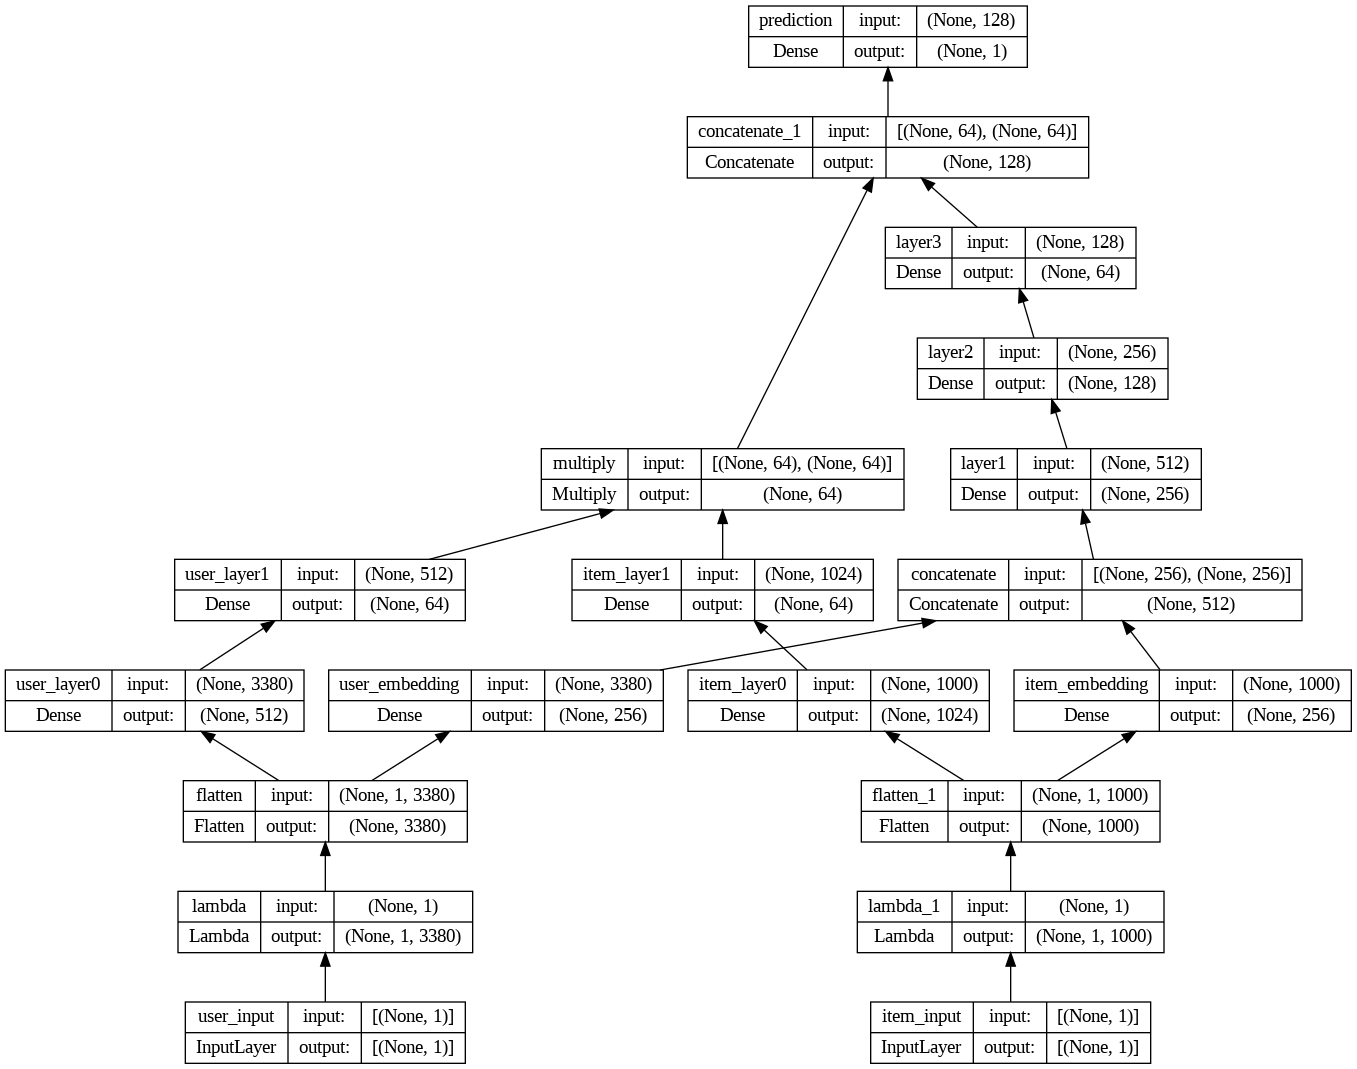

In [7]:
# 신경망 시각화
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="BT")

In [8]:
# 미리 설정한 옵티마이저와 학습율을 반영하여 compile 수행
if learner.lower() == "adagrad":
    model.compile(optimizer=Adagrad(learning_rate=learning_rate), loss='binary_crossentropy')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='binary_crossentropy')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy')
else:
    model.compile(optimizer=SGD(learning_rate=learning_rate), loss='binary_crossentropy')

##### Train & evaluate model

In [9]:
# 매 epoch 마다 negative sampling 수행
def get_train_instances(train, num_items, num_negatives):
    user_input, item_input, labels = [], [], []
    for (u, i) in train.keys():
        # positive samples
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        # negative samples: 각 positive 아이템에 대하여, num_negatives 개수 만큼의 negative 아이템을 생성
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            while (u, j) in train.keys():  # 샘플링된 negative 아이템이 positive 아이템이면 다시 샘플링
                j = np.random.randint(num_items)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels

In [10]:
# 매 epoch 마다 hit-rate와 NDCG 측정 (Why: RecSys 평가척도와 DNN 평가척도는 상이)
def evaluate_model(model, test_positives, test_negatives, K):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    hits, ndcgs = [], []  # 사용자별로 hit, ndcg 값 저장

    for idx in range(len(test_positives)):
        u, gt_item = test_positives[idx]        # testPositives의 각 원소는 [사용자ID, Positive아이템ID] 형식
        items = test_negatives[idx] + [gt_item] # testNegatives의 각 원소는 [Negative아이템-1, Negative아이템-2, ...] 형식
                                                # Positive아이템ID도 items 리스트에 추가(???)

        # Get prediction scores: Negative아이템 갯수만큼 사용자ID를 채워 inference
        predictions = model.predict([np.full(len(items), u, dtype='int32'), np.array(items)], batch_size=100, verbose=0)
        map_item_score = {item: pred for item, pred in zip(items, predictions.flatten())} # {아이템ID: 예측값} 형식

        # Evaluate top rank list
        ranklist = heapq.nlargest(K, map_item_score, key=map_item_score.get)
        hr = int(gt_item in ranklist)
        ndcg = math.log(2) / math.log(ranklist.index(gt_item) + 2) if gt_item in ranklist else 0

        hits.append(hr)
        ndcgs.append(ndcg)

    return hits, ndcgs

In [11]:
best_hr, best_ndcg, best_iter = 0, 0, -1

for epoch in range(num_epochs):
    start_time = time()

    # Generate training samples
    user_input, item_input, labels = get_train_instances(train, num_items, num_negatives)

    # Training
    user_input = np.array(user_input)
    item_input = np.array(item_input)
    labels = np.array(labels)

    hist = model.fit([user_input, item_input], labels,
                     batch_size=batch_size, epochs=1, verbose=0, shuffle=True)

    training_time = time() - start_time

    # Evaluation
    (hits, ndcgs) = evaluate_model(model, testPositives, testNegatives, topK)
    hr, ndcg, loss = np.mean(hits), np.mean(ndcgs), hist.history['loss'][0]  # 사용자별 hit-rate와 ndcg를 평균

    # Monitoring
    evaluation_time = time() - start_time - training_time
    print(f'Iteration {epoch} [{training_time:.1f} s]: HR = {hr:.4f}, NDCG = {ndcg:.4f}, '
          f'loss = {loss:.4f} [{evaluation_time:.1f} s]')

    # Save the best model
    if hr > best_hr:
        best_hr, best_ndcg, best_iter = hr, ndcg, epoch

print(f"End. Best Iteration {best_iter}:  HR = {best_hr:.4f}, NDCG = {best_ndcg:.4f}. ")

Iteration 0 [23.6 s]: HR = 0.2080, NDCG = 0.1072, loss = 0.6854 [58.4 s]
Iteration 1 [8.7 s]: HR = 0.2210, NDCG = 0.1171, loss = 0.6714 [56.7 s]
Iteration 2 [6.4 s]: HR = 0.2460, NDCG = 0.1308, loss = 0.6602 [57.3 s]
End. Best Iteration 2:  HR = 0.2460, NDCG = 0.1308. 


<font color='tomato'><font color="#CC3D3D"><p>
# End